In [1]:
# load in libraries
import pandas as pd
import os
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Read in processed airports data
# Airports with aerial firefighting capabilities
airports_dir = os.path.join(os.getcwd(), '../data/raw_data/airports_processed.csv')
airports = pd.read_csv(airports_dir)

In [3]:
# view
airports.head()

,ident,iata_code,icao_code,local_code,runway_lengths_ft,name,type,runway_surfaces,country_name,region_name,latitude_deg,longitude_deg
0,0R7,NaN,NaN,0R7,5000,The Red River Airport,small_airport,asphalt,United States,Louisiana,31.990700,-93.307404
1,5K2,NaN,NaN,5K2,5000,Tribune Municipal Airport,small_airport,grooved concrete,United States,Kansas,38.450901,-101.750135
2,C56,NaN,NaN,C56,5001,Bult Field,small_airport,grooved concrete,United States,Illinois,41.377602,-87.681396
3,D38,IUA,NaN,IUA,5500,Canandaigua Airport,small_airport,asphalt,United States,New York,42.908902,-77.325226
4,FWB,NaN,NaN,FWB,5000,Branson West Airport,small_airport,grooved concrete,United States,Missouri,36.698497,-93.402249


In [4]:
# get data info
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ident              1394 non-null   object 
 1   iata_code          1006 non-null   object 
 2   icao_code          965 non-null    object 
 3   local_code         1394 non-null   object 
 4   runway_lengths_ft  1394 non-null   object 
 5   name               1394 non-null   object 
 6   type               1394 non-null   object 
 7   runway_surfaces    1394 non-null   object 
 8   country_name       1394 non-null   object 
 9   region_name        1394 non-null   object 
 10  latitude_deg       1394 non-null   float64
 11  longitude_deg      1394 non-null   float64
dtypes: float64(2), object(10)
memory usage: 130.8+ KB


In [5]:
# Count null values in each column of the filtered dataset
null_counts = airports.isnull().sum()
# Print the result
print("Null values in each column:")
print(null_counts.sort_values(ascending=False))

Null values in each column:
icao_code            429
iata_code            388
ident                  0
local_code             0
runway_lengths_ft      0
name                   0
type                   0
runway_surfaces        0
country_name           0
region_name            0
latitude_deg           0
longitude_deg          0
dtype: int64


In [6]:
# compute the number of airports in the US actually have wildfire capabilities
# get all airports
airports_raw_dir = os.path.join(os.getcwd(), '../data/raw_data/our_airports_raw/airports.csv')
airports_raw = pd.read_csv(
    airports_raw_dir
)

# Filter all U.S. airports from raw dataset
us_airports = airports_raw[airports_raw['iso_country'] == 'US']
total_us_airports = len(us_airports)

# Get number of aerial firefighting airports (already filtered to US)
num_firefighting_airports = len(airports)

# Compute proportion
proportion = num_firefighting_airports / total_us_airports if total_us_airports > 0 else 0
percentage = proportion * 100

# Output fraction and percentage
print(f"Fraction of U.S. airports with aerial firefighting capabilities: "
      f"{num_firefighting_airports}/{total_us_airports}")

print(f"Percentage of U.S. airports with aerial firefighting capabilities: "
      f"{percentage:.2f}%")

Fraction of U.S. airports with aerial firefighting capabilities: 1394/32098
Percentage of U.S. airports with aerial firefighting capabilities: 4.34%


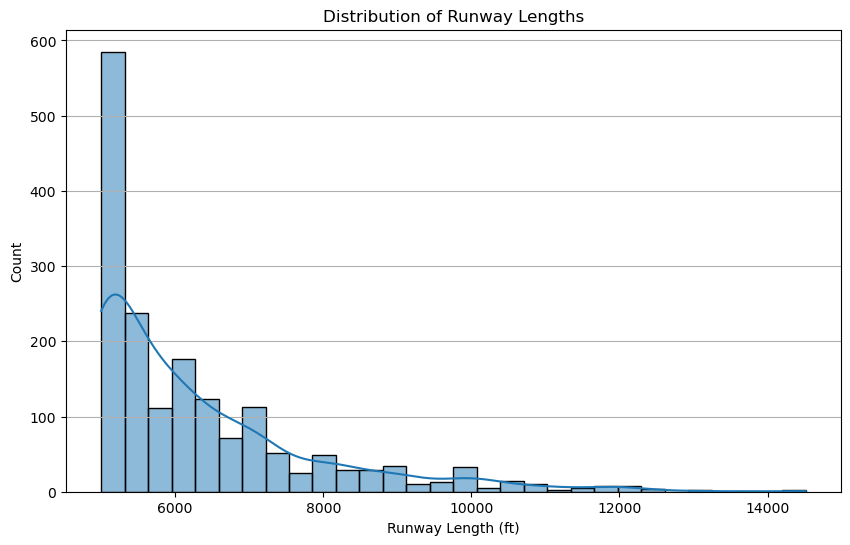

In [7]:
# Convert runway_lengths_ft to list of ints
airports['runway_lengths_list'] = airports['runway_lengths_ft'].dropna().apply(
    lambda x: [int(i) for i in str(x).split(',') if i.strip().isdigit()]
)

# Explode for histogram of individual runway lengths
runway_lengths_all = airports.explode('runway_lengths_list')
runway_lengths_all['runway_lengths_list'] = runway_lengths_all['runway_lengths_list'].astype(float)

plt.figure(figsize=(10, 6))
ax = sns.histplot(runway_lengths_all['runway_lengths_list'], bins=30, kde=True)
plt.xlabel('Runway Length (ft)')
plt.title('Distribution of Runway Lengths')

# Only show horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

plt.show()


In [8]:
# Compute stats
runway_series = runway_lengths_all['runway_lengths_list']
runway_stats = runway_series.describe()
iqr = runway_stats['75%'] - runway_stats['25%']
mode_val = runway_series.mode()

# Outlier thresholds
lower_bound = runway_stats['25%'] - 1.5 * iqr
upper_bound = runway_stats['75%'] + 1.5 * iqr

# Identify outliers
outliers = runway_series[(runway_series < lower_bound) | (runway_series > upper_bound)]

# Summary output
print("Runway Lengths Statistics (ft):")
print(f"Mode: {mode_val.iloc[0] if not mode_val.empty else 'No mode'}")
print(f"Mean: {runway_stats['mean']:.2f}")
print(f"Median: {runway_series.median():.2f}")
print(f"Std: {runway_stats['std']:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Min: {runway_stats['min']}")
print(f"Max: {runway_stats['max']}")
print(f"\nOutlier Thresholds: < {lower_bound:.2f} or > {upper_bound:.2f}")
print(f"Number of Outliers: {len(outliers)}")

# Optional: print extreme outliers
if not outliers.empty:
    print("\nSample Outliers:")
    print(outliers.sort_values().head(5))
    print(outliers.sort_values(ascending=False).head(5))


Runway Lengths Statistics (ft):
Mode: 5000.0
Mean: 6298.81
Median: 5800.00
Std: 1557.68
IQR: 1862.00
Min: 5000.0
Max: 14515.0

Outlier Thresholds: < 2307.00 or > 9755.00
Number of Outliers: 92

Sample Outliers:
247      9763.0
749      9771.0
1393     9800.0
1103     9999.0
116     10000.0
Name: runway_lengths_list, dtype: float64
749    14515.0
717    14511.0
108    13793.0
388    13125.0
863    13000.0
Name: runway_lengths_list, dtype: float64


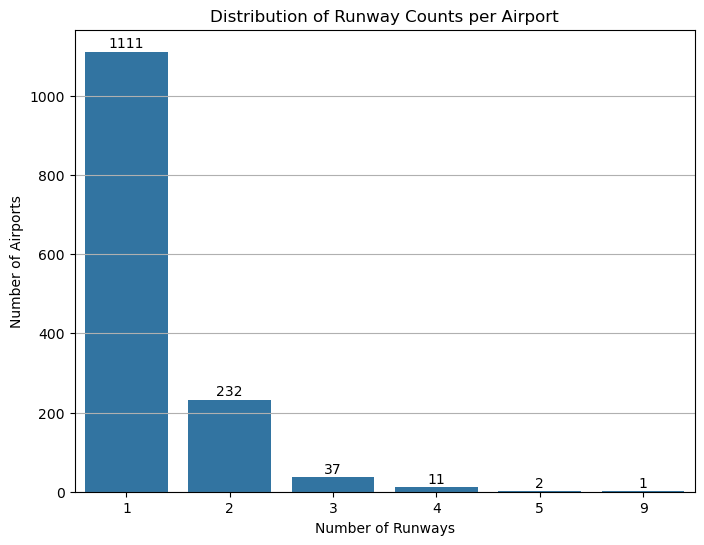

In [9]:
# Analyze Number of Runways per Airport
airports['num_runways'] = airports['runway_lengths_list'].apply(len)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=airports['num_runways'])

plt.xlabel('Number of Runways')
plt.ylabel('Number of Airports')
plt.title('Distribution of Runway Counts per Airport')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add count labels above bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 10, str(count), ha='center')

plt.show()


In [10]:
# Descriptive Stats for runway counts
runway_count_stats = airports['num_runways'].describe()
iqr_runways = runway_count_stats['75%'] - runway_count_stats['25%']

print("\nNumber of Runways per Airport Statistics:")
print(f"Mode: {airports['num_runways'].mode()[0]}")
print(f"Min: {runway_count_stats['min']}")
print(f"Max: {runway_count_stats['max']}")

# Optional: frequency table
print("\nRunway Count Frequencies:")
print(airports['num_runways'].value_counts().sort_index())



Number of Runways per Airport Statistics:
Mode: 1
Min: 1.0
Max: 9.0

Runway Count Frequencies:
num_runways
1    1111
2     232
3      37
4      11
5       2
9       1
Name: count, dtype: int64


In [11]:
# Show airport(s) with 9 runways
airports_with_9_runways = airports[airports['num_runways'] == 9]

# Display the result
print("Airport(s) with 9 runways:")
print(airports_with_9_runways['name'])


Airport(s) with 9 runways:
965    Chicago O'Hare International Airport
Name: name, dtype: object


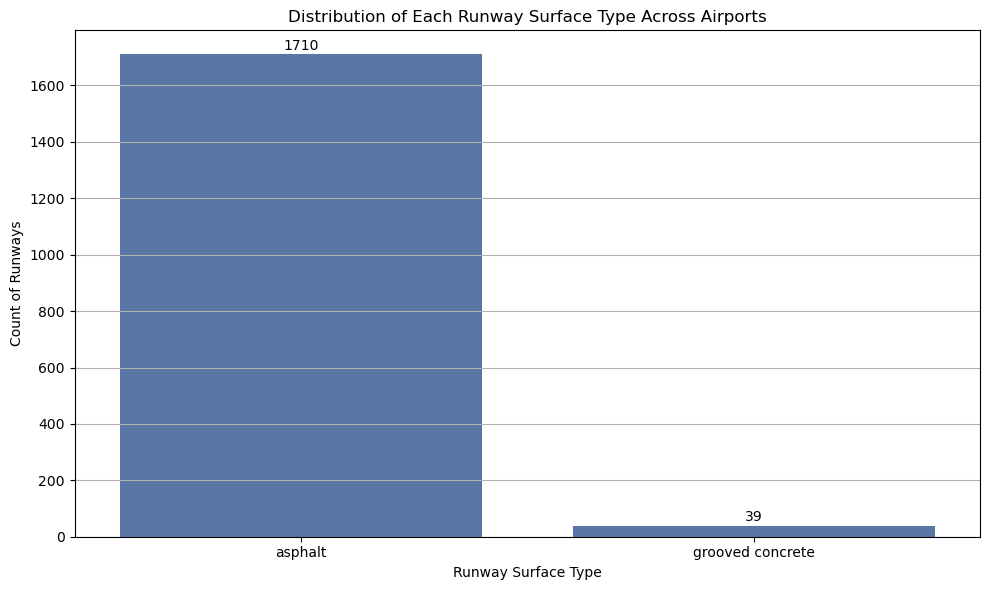

In [13]:
# Convert 'runway_surfaces' strings to lists
airports['runway_surfaces_list'] = airports['runway_surfaces'].dropna().apply(
    lambda x: [s.strip() for s in str(x).split(',')]
)

# Explode so each surface is a row
surfaces_all = airports.explode('runway_surfaces_list')

# Count occurrences of each surface
surface_counts = surfaces_all['runway_surfaces_list'].value_counts().sort_values(ascending=False)

# Get the default deep palette first color (Seaborn's default blue)
default_blue = sns.color_palette("deep")[0]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=surface_counts.index, y=surface_counts.values, color=default_blue)

plt.xlabel('Runway Surface Type')
plt.ylabel('Count of Runways')
plt.title('Distribution of Each Runway Surface Type Across Airports')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + max(surface_counts.values)*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()


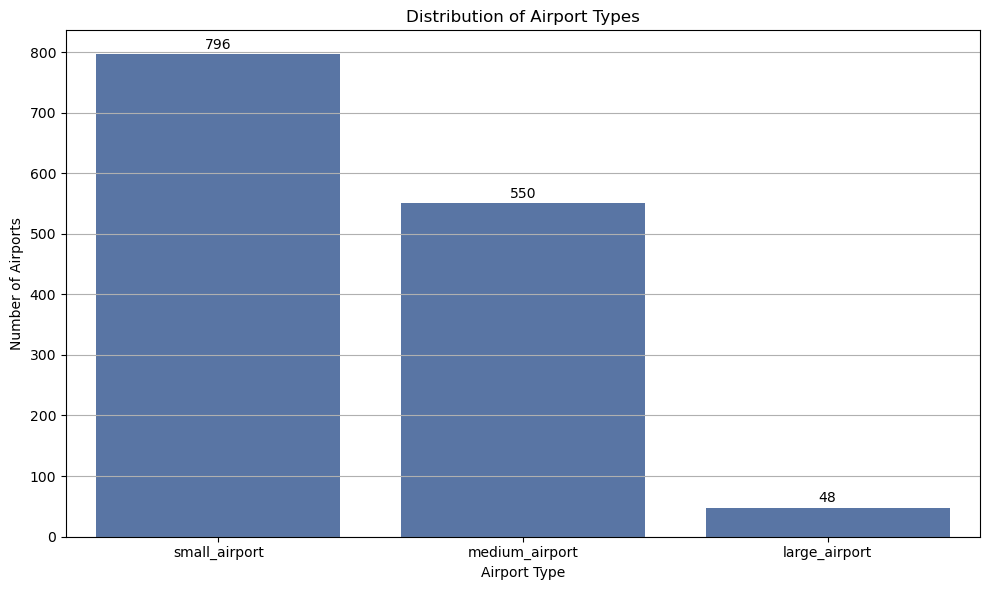

In [15]:
# airport type plot

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=airports, x='type', color=sns.color_palette("deep")[0])

plt.xlabel('Airport Type')
plt.ylabel('Number of Airports')
plt.title('Distribution of Airport Types')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + max(ax.get_ylim())*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# Drop rows with missing coordinates
airports = airports.dropna(subset=['latitude_deg', 'longitude_deg'])

# Create interactive map centered over the continental US
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

# Add airport points with all column data in popup
for _, row in airports.iterrows():
    popup_html = "<br>".join([f"<b>{col}:</b> {row[col]}" for col in airports.columns])
    folium.CircleMarker(
        location=[row['latitude_deg'], row['longitude_deg']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=row['name'] if 'name' in row else 'Airport'
    ).add_to(m)

# Save the interactive map to an HTML file
m.save('interactive_airport_map.html')

In [ ]:
# display
m